In [1]:
import pandas as pd
import numpy as np
import matplotlib

#### Import the ipo info file, which has ipo first trade date:

In [6]:
ipo_info_file_path = 'data/raw/IPO_Info.csv'
ipo_info_df = pd.read_csv(ipo_info_file_path)
ipo_info_df.drop(ipo_info_df.iloc[:, 5:9], axis=1, inplace=True)
ipo_info_df['IPO Date'] = pd.to_datetime(ipo_info_df['IPO Date'])

#### Import the IPO end of day data file:

In [8]:
ipo_eod_data_file_path = 'data/raw/EOD_Data.csv'
ipo_eod_data_df = pd.read_csv(ipo_eod_data_file_path)

In [9]:
%%time
ipo_eod_data_df['Date'] = pd.to_datetime(ipo_eod_data_df['Date'])

Wall time: 1min 38s


In [10]:
ipo_info_df['Symbol'].count()

917

In [11]:
# a structure to store execution data
execution = {
    'quantity':0,
    'symbol':'',
    'price':0.0,
    'date':''
}

# a strcuture to store daily returns for equity curve
daily_returns = {
    'date':'',
    'pnl':0.0
}

In [12]:
class moving_average:
    
    def __init__(self, length):
        self.length = length
        self.value_queue = []
        
    def add_val(self, val):
        self.value_queue.append(val)
        if len(self.value_queue) > self.length:
            self.value_queue.pop(0)
            
    def current_val(self):
        return sum(self.value_queue)/float(len(self.value_queue))
    
    def get_length(self):
        return len(self.value_queue)
    
    def __delitem__(self):
        self.value_queue[:] = []
    

In [15]:
# this version uses moving average for the stop
def backtest_symbol(symbol, start_date):
    
    
    # get the price data starting from IPO Date sorted by date
    price_data = ipo_eod_data_df[(ipo_eod_data_df.Symbol==symbol) & (ipo_eod_data_df.Date >= start_date)].sort_values(by=['Date'])
    
    days_since_ipo = 0
    all_time_high = 0.0
    low0 = 99990.0
    low1 = 99990.0
    low2 = 99990.0
    low3 = 99990.0
    DOLLAR_PER_POSITION = 10000
    
    entry_triggered = False
    
    execution_list = []
    daily_returns_list = []
    position = 0
    previous_close = 0
    entry_date = ''
    ma_length = 20
    ma = moving_average(ma_length)
    
    # iterate through the days starting with ipo date
    for index, row in price_data.iterrows():
        if entry_triggered:
            position = int(DOLLAR_PER_POSITION/previous_close)
            execution_list.append({'Quantity':position,'Symbol':symbol,'Price':row['VWAP'],'Date':row['Date']})
            entry_date = row['Date']
            entry_triggered = False
        
              
        
        days_since_ipo += 1
        
        new_high = False
        if row['High'] > all_time_high: 
            all_time_high = row['High']
            new_high = True
            
        # update 3 day low
        low3 = low2
        low2 = low1
        low1 = low0
        low0 = row['Low']
        
        three_day_low = min(low1,low2,low3)
        
        # check if entry triggered
        if (position == 0
            and days_since_ipo > 5 
            and new_high):
            entry_triggered = True 
            #note: will enter next day vwap
            
        # check if stopped out
        if position != 0:
            stop_price = min(ma.current_val, three_day_low)
            if (row['Low'] < stop_price
                and entry_triggered == False):
                execution_list.append({'Quantity':(position*-1),'Symbol':symbol,'Price':stop_price,'Date':row['Date']})
                daily_returns_list.append({'Date':row['Date'],'pnl':((stop_price - previous_close) * position)})
                position = 0
            else:
                # record daily returns
                change = 0.0
                if entry_date == row['Date']:
                    # today was the entry
                    change = row['Close'] - row['VWAP']
                else:
                    change = row['Close'] - previous_close
                
                daily_returns_list.append({'Date':row['Date'],'pnl':(change * position)})
                
        # update moving avg
        ma.add_val(row['Close'])  
            
        previous_close = row['Close']
        
              
    executions_df = pd.DataFrame(execution_list)
    daily_returns_df = pd.DataFrame(daily_returns_list)
        
    return (executions_df,daily_returns_df)

#### Test 1 Symbol

In [16]:
result_tuple = backtest_symbol('ROKU','2017-09-28')

Trades in ROKU:

In [17]:
result_tuple[0]

,Date,Price,Quantity,Symbol
0,2017-11-13,41.2980,300,ROKU
1,2017-11-21,37.7500,-300,ROKU
2,2017-11-29,45.2236,215,ROKU
3,2017-12-04,42.3100,-215,ROKU
4,2017-12-18,55.5069,191,ROKU
5,2017-12-21,52.4300,-191,ROKU


Roku daily returns:

In [18]:
result_tuple[1]

,Date,pnl
0,2017-11-13,423.6000
1,2017-11-14,-1728.0000
2,2017-11-15,711.0000
3,2017-11-16,141.0000
4,2017-11-17,-360.0000
5,2017-11-20,129.0000
6,2017-11-21,-381.0000
7,2017-11-29,-76.0240
8,2017-11-30,-208.5500
9,2017-12-01,-75.2500


#### Test All Stocks and time execution:

In [19]:
%%time
# iterate through the symbol list
all_executions = None
all_returns = None
for index, row in ipo_info_df.iterrows():
    
    symbol = row['Symbol']
    start_date = row['IPO Date']
    
    results = backtest_symbol(symbol, start_date)
    
    if all_executions is None:
        all_executions = results[0]
        all_returns = results[1]
    else:
        all_executions = pd.concat([all_executions, results[0]])
        all_returns = pd.concat([all_returns, results[1]])
sorted_returns = all_returns.sort_values(['Date'])
returns = sorted_returns.groupby(['Date'])['pnl'].sum()   
cumulative_sums = returns.cumsum()
all_executions['abs_shares'] = abs(all_executions['Quantity'])
shares_traded = all_executions.abs_shares.sum()
gross = all_returns.sum()
commission = shares_traded * .007
net = gross - commission
cps = gross / shares_traded

Wall time: 1min 36s


In [20]:
number_of_trades = all_executions.count()

In [21]:
%matplotlib inline

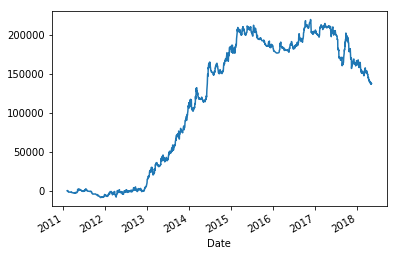

In [22]:
cumulative_sums.plot.line()

In [23]:
shares_traded

3181228

In [24]:
gross

pnl    137453.6028
dtype: float64

In [25]:
commission

22268.596

In [26]:
net

pnl    115185.0068
dtype: float64

In [27]:
cps

pnl    0.043208
dtype: float64

In [29]:
number_of_trades['Symbol']

6214